### 필요 함수 정의

In [14]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

### 필수 라이브러리

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import copy
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.metrics import roc_curve, auc

### 데이터셋 읽어오기

In [16]:
df_train = pd.read_csv('new_imputation_train_pre.csv')
df_test = pd.read_csv('new_imputation_test_pre.csv')

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55840 entries, 0 to 55839
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              55840 non-null  float64
 1   customer_country         55840 non-null  int64  
 2   business_unit            55840 non-null  int64  
 3   com_reg_ver_win_rate     55840 non-null  float64
 4   customer_idx             55840 non-null  int64  
 5   customer_type            55840 non-null  int64  
 6   enterprise               55840 non-null  int64  
 7   historical_existing_cnt  55840 non-null  float64
 8   id_strategic_ver         55840 non-null  float64
 9   it_strategic_ver         55840 non-null  float64
 10  idit_strategic_ver       55840 non-null  float64
 11  customer_job             55840 non-null  int64  
 12  lead_desc_length         55840 non-null  int64  
 13  inquiry_type             55840 non-null  int64  
 14  product_category      

# 모델링 준비

### 학습 데이터 분리

In [18]:
X = df_train.drop("is_converted", axis=1)
y = df_train['is_converted']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [19]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
categorical_features = ['business_unit','customer_idx','customer_type', 'enterprise',
       'customer_job', 'inquiry_type', 'product_category',
       'customer_position', 'response_corporate', 'expected_timeline',
       'business_area', 'business_subarea', 'lead_owner', 'customer_country', 'ver_cus', 'ver_pro', 
       'id_strategic_ver', 'idit_strategic_ver', 'it_strategic_ver', 'historical_existing_cnt', 'null_count', 'bant_submit']
for cat_feature in categorical_features:
    X_train[cat_feature] = X_train[cat_feature].astype('category')
    X_val[cat_feature] = X_val[cat_feature].astype('category')

# 모델 학습

In [121]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_metric
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve
import seaborn as sns
import warnings;warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance

# regression for stacking model
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import VotingClassifier,  RandomForestClassifier, StackingClassifier, ExtraTreesClassifier

In [22]:
# f1 score
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [23]:
### n_trials 공통으로 정하기
n_trial = 2
seed = 42
n_split = 10

### 1. LGBM

In [24]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',1,1000),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    }

    model = LGBMClassifier(**params, device = 'cpu', random_state=seed, verbose=-1)

    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    cv = cross_val_score(model, X_train, y_train, scoring=f1_scorer,cv=skf).mean()
    
    return cv

In [25]:
%%time
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective, n_trials=n_trial)

[I 2024-02-22 17:05:42,454] A new study created in memory with name: no-name-ba69eec2-522b-4c4d-abfc-10afca7858e0
[I 2024-02-22 17:07:00,155] Trial 0 finished with value: 0.970184523379244 and parameters: {'n_estimators': 904, 'max_depth': 15, 'learning_rate': 0.0003915814929361089, 'reg_alpha': 0.04669952967822009, 'reg_lambda': 0.6905570329336673, 'min_child_weight': 1.0882978627860775, 'min_child_samples': 65, 'subsample': 0.8058897506799604, 'subsample_freq': 3, 'colsample_bytree': 0.9974693872173808, 'num_leaves': 50}. Best is trial 0 with value: 0.970184523379244.
[I 2024-02-22 17:07:09,959] Trial 1 finished with value: 0.9809605003533687 and parameters: {'n_estimators': 85, 'max_depth': 21, 'learning_rate': 0.028446781737034823, 'reg_alpha': 0.010053279848528893, 'reg_lambda': 0.06612699709934759, 'min_child_weight': 3.9668517575515314, 'min_child_samples': 10, 'subsample': 0.8013017998620166, 'subsample_freq': 4, 'colsample_bytree': 0.8905093899855834, 'num_leaves': 62}. Best i

CPU times: user 5min 36s, sys: 1.07 s, total: 5min 38s
Wall time: 1min 27s


In [26]:
print('Best trial: score {}, \nparams {}'.format(study_lgbm.best_trial.value,
                                                 study_lgbm.best_trial.params))

Best trial: score 0.9809605003533687, 
params {'n_estimators': 85, 'max_depth': 21, 'learning_rate': 0.028446781737034823, 'reg_alpha': 0.010053279848528893, 'reg_lambda': 0.06612699709934759, 'min_child_weight': 3.9668517575515314, 'min_child_samples': 10, 'subsample': 0.8013017998620166, 'subsample_freq': 4, 'colsample_bytree': 0.8905093899855834, 'num_leaves': 62}


### 학습

In [27]:
best_params_lgbm = study_lgbm.best_params
best_model_lgbm = LGBMClassifier(**best_params_lgbm, random_state=seed)
best_model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 46124, number of negative: 46124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 92248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(colsample_bytree=0.8905093899855834,
               learning_rate=0.028446781737034823, max_depth=21,
               min_child_samples=10, min_child_weight=3.9668517575515314,
               n_estimators=85, num_leaves=62, random_state=42,
               reg_alpha=0.010053279848528893, reg_lambda=0.06612699709934759,
               subsample=0.8013017998620166, subsample_freq=4)

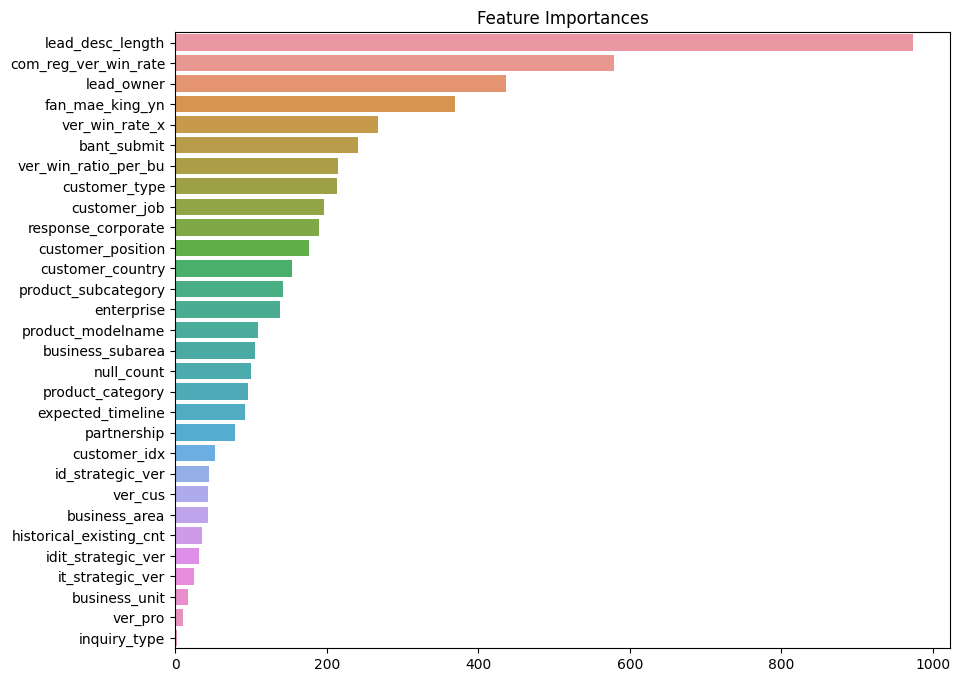

In [28]:
# 위 feature importance를 시각화해봅니다.
importances_lgbm = pd.Series(best_model_lgbm.feature_importances_, index=list(X_train.columns))
importances_lgbm = importances_lgbm.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_lgbm, y=importances_lgbm.index)
plt.show()

In [29]:
y_pred_proba_lgbm = best_model_lgbm.predict_proba(X_val)[:, 1]

In [30]:
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_val, y_pred_proba_lgbm)

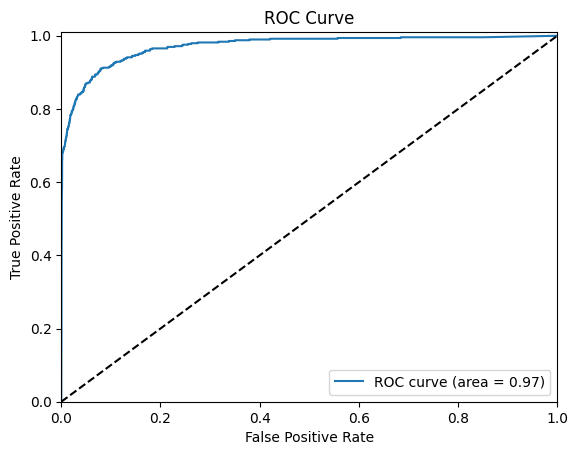

In [31]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm, label='ROC curve (area = %0.2f)' % auc(fpr_lgbm, tpr_lgbm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
# 적정 임계값 찾기
optimal_idx_lgbm = np.argmax(tpr_lgbm - fpr_lgbm)
optimal_threshold_lgbm = thresholds_lgbm[optimal_idx_lgbm]
print("Optimal threshold:", optimal_threshold_lgbm)

Optimal threshold: 0.12754217936181048


In [33]:
y_pred_custom_threshold_lgbm = (y_pred_proba_lgbm >= optimal_threshold_lgbm).astype(int)

In [34]:
### 기본 쓰레스홀드
pred_lgbm = best_model_lgbm.predict(X_val)
get_clf_eval(y_val, pred_lgbm)

오차행렬:
 [[ 363  130]
 [  59 5032]]

정확도: 0.9662
정밀도: 0.8602
재현율: 0.7363
F1: 0.7934


In [35]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_lgbm)

오차행렬:
 [[ 449   44]
 [ 405 4686]]

정확도: 0.9196
정밀도: 0.5258
재현율: 0.9108
F1: 0.6667


### 2. RF

In [36]:
# optuna 학습 메소드 선언
def objective_RF(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }

    model = RandomForestClassifier(**param)
    
    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    cv = cross_val_score(model, X, y, scoring=f1_scorer, cv=skf).mean()
    
    return cv

In [37]:
%%time
study_rf = optuna.create_study(study_name='RF', direction="maximize")
study_rf.optimize(lambda trial: objective_RF(trial, X_train, y_train),
                  n_trials = n_trial)

[I 2024-02-22 17:07:11,686] A new study created in memory with name: RF
[W 2024-02-22 17:27:02,435] Trial 0 failed with parameters: {'n_estimators': 1117, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 0.9009068904858295, 'bootstrap': False} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 2, in <lambda>
  File "/tmp/ipykernel_225/3335947067.py", line 19, in objective_RF
    cv = cross_val_score(model, X, y, scoring=f1_scorer, cv=skf).mean()
  File "/home/elicer/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/home/elicer/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate

KeyboardInterrupt: 

In [38]:
# print하자
print('Best trial: score {}, \nparams {}'.format(study_rf.best_trial.value,
                                                 study_rf.best_trial.params))

ValueError: No trials are completed yet.

In [ ]:
# best models for rf
best_params_rf = study_rf.best_params
best_model_rf = RandomForestClassifier(**best_params_rf, random_state=seed)
best_model_rf.fit(X_train, y_train)

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances_rf = pd.Series(best_model_rf.feature_importances_, index=list(X_train.columns))
importances_rf = importances_rf.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_rf, y=importances_rf.index)
plt.show()

In [ ]:
y_pred_proba_rf = best_model_rf.predict_proba(X_val)[:, 1]

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_pred_proba_rf)

In [ ]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='ROC curve (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 적정 임계값 찾기
optimal_idx_rf = np.argmax(tpr_rf - fpr_rf)
optimal_threshold_rf = thresholds_rf[optimal_idx_rf]
print("Optimal threshold:", optimal_threshold_rf)

In [ ]:
y_pred_custom_threshold_rf = (y_pred_proba_rf >= optimal_threshold_rf).astype(int)

In [ ]:
### 기본 쓰레스홀드
pred_rf = best_model_rf.predict(X_val)
get_clf_eval(y_val, pred_rf)

In [ ]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_rf)

### 3. ET

In [39]:
# optuna 학습 메소드 선언
def objective_ET(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2),
        'random_state': seed
    }
    model = ExtraTreesClassifier(**param)
    
    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    cv = cross_val_score(model, X, y, scoring=f1_scorer, cv=skf).mean()
    
    return cv

In [40]:
%%time
study_et = optuna.create_study(study_name='ET', direction="maximize")
study_et.optimize(lambda trial: objective_ET(trial, X_train, y_train),
                  n_trials = n_trial)

[I 2024-02-22 17:27:15,282] A new study created in memory with name: ET
[I 2024-02-22 17:28:46,380] Trial 0 finished with value: 0.8446292575603886 and parameters: {'n_estimators': 737, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.42478356632437386, 'bootstrap': False, 'criterion': 'gini', 'min_impurity_decrease': 0.13755871855819896}. Best is trial 0 with value: 0.8446292575603886.
[I 2024-02-22 17:29:03,655] Trial 1 finished with value: 0.8991996020455126 and parameters: {'n_estimators': 102, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.4910975500533088, 'bootstrap': True, 'criterion': 'entropy', 'min_impurity_decrease': 0.024470532883400998}. Best is trial 1 with value: 0.8991996020455126.


CPU times: user 1min 48s, sys: 24 ms, total: 1min 48s
Wall time: 1min 48s


In [41]:
# print하자
print('Best trial: score {}, \nparams {}'.format(study_et.best_trial.value,
                                                 study_et.best_trial.params))

Best trial: score 0.8991996020455126, 
params {'n_estimators': 102, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.4910975500533088, 'bootstrap': True, 'criterion': 'entropy', 'min_impurity_decrease': 0.024470532883400998}


In [42]:
# best models for rf
best_params_et = study_et.best_params
best_model_et = ExtraTreesClassifier(**best_params_et, random_state=42)
best_model_et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=13,
                     max_features=0.4910975500533088,
                     min_impurity_decrease=0.024470532883400998,
                     min_samples_leaf=9, min_samples_split=8, n_estimators=102,
                     random_state=42)

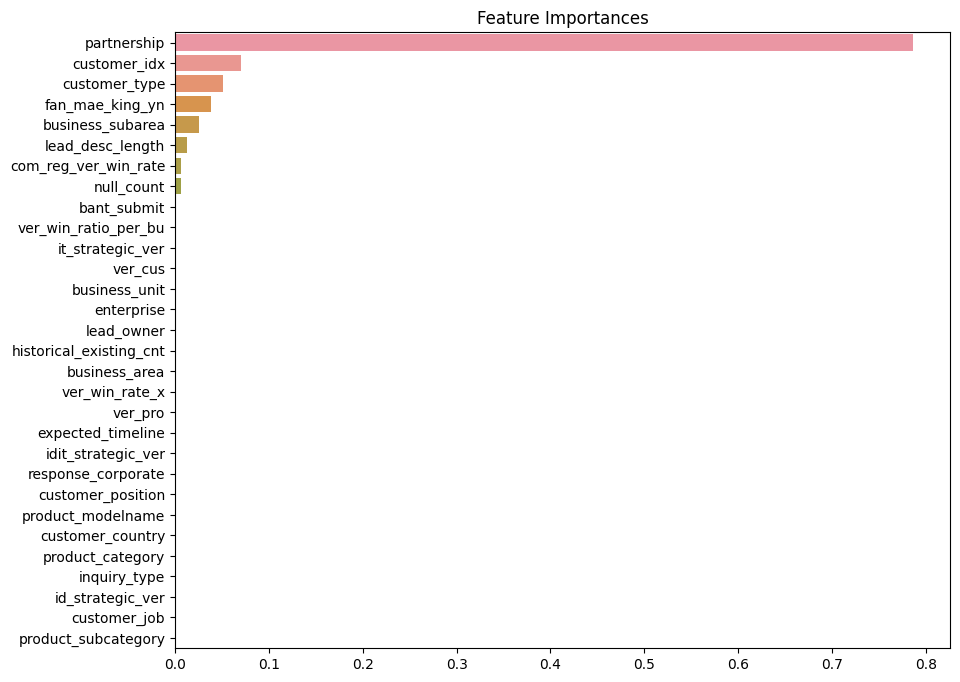

In [43]:
# 위 feature importance를 시각화해봅니다.
importances_et = pd.Series(best_model_et.feature_importances_, index=list(X_train.columns))
importances_et = importances_et.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_et, y=importances_et.index)
plt.show()

In [44]:
y_pred_proba_et = best_model_et.predict_proba(X_val)[:, 1]

In [45]:
fpr_et, tpr_et, thresholds_et = roc_curve(y_val, y_pred_proba_et)

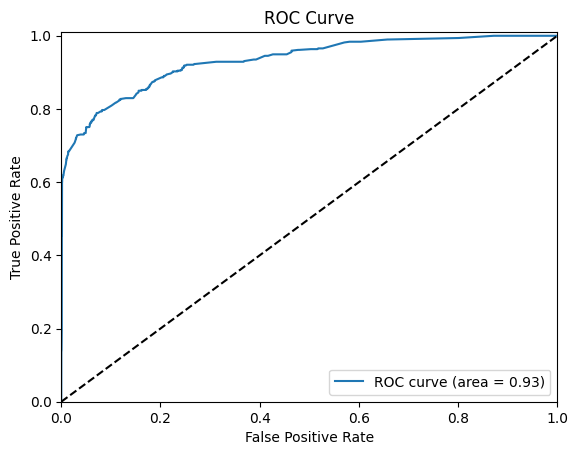

In [46]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_et, tpr_et, label='ROC curve (area = %0.2f)' % auc(fpr_et, tpr_et))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
# 적정 임계값 찾기
optimal_idx_et = np.argmax(tpr_et - fpr_et)
optimal_threshold_et = thresholds_et[optimal_idx_et]
print("Optimal threshold:", optimal_threshold_et)

Optimal threshold: 0.3818758929344947


In [48]:
y_pred_custom_threshold_et = (y_pred_proba_et >= optimal_threshold_et).astype(int)

In [49]:
### 기본 쓰레스홀드
pred_et = best_model_et.predict(X_val)
get_clf_eval(y_val, pred_et)

오차행렬:
 [[ 296  197]
 [   9 5082]]

정확도: 0.9631
정밀도: 0.9705
재현율: 0.6004
F1: 0.7419


In [50]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_et)

오차행렬:
 [[ 389  104]
 [ 363 4728]]

정확도: 0.9164
정밀도: 0.5173
재현율: 0.7890
F1: 0.6249


### 4. XGB

In [58]:
# optuna 학습 메소드 선언
def objective_XGB(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': seed,
        'enable_categorical': True
    }
    model = XGBClassifier(**param)
    
    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    cv = cross_val_score(model, X, y, scoring=f1_scorer, cv=skf).mean()
    
    return cv

In [60]:
%%time
study_xgb = optuna.create_study(study_name='XGB', direction="maximize")
study_xgb.optimize(lambda trial: objective_XGB(trial, X_train, y_train),
                  n_trials = n_trial)

[I 2024-02-22 17:31:00,692] A new study created in memory with name: XGB
[I 2024-02-22 17:32:25,663] Trial 0 finished with value: 0.9834949464857328 and parameters: {'n_estimators': 767, 'max_depth': 3, 'learning_rate': 0.032642785163691866, 'subsample': 0.722526479699263, 'colsample_bytree': 0.7280123788216765, 'gamma': 0.2894011638702749, 'reg_alpha': 0.5355185828403999, 'reg_lambda': 0.23788545298358765, 'min_child_weight': 1}. Best is trial 0 with value: 0.9834949464857328.
[I 2024-02-22 17:39:48,929] Trial 1 finished with value: 0.9859688750258643 and parameters: {'n_estimators': 804, 'max_depth': 8, 'learning_rate': 0.038656302483763276, 'subsample': 0.7272457512152986, 'colsample_bytree': 0.954030136531604, 'gamma': 0.7293043697968278, 'reg_alpha': 0.35965381677460095, 'reg_lambda': 0.9528162415309932, 'min_child_weight': 7}. Best is trial 1 with value: 0.9859688750258643.


CPU times: user 34min 53s, sys: 2.42 s, total: 34min 56s
Wall time: 8min 48s


In [61]:
# print하자
print('Best trial: score {}, \nparams {}'.format(study_xgb.best_trial.value,
                                                 study_xgb.best_trial.params))

Best trial: score 0.9859688750258643, 
params {'n_estimators': 804, 'max_depth': 8, 'learning_rate': 0.038656302483763276, 'subsample': 0.7272457512152986, 'colsample_bytree': 0.954030136531604, 'gamma': 0.7293043697968278, 'reg_alpha': 0.35965381677460095, 'reg_lambda': 0.9528162415309932, 'min_child_weight': 7}


In [63]:
# best models for rf
best_params_xgb = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params_xgb, random_state=42, enable_categorical = True)
best_model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.954030136531604, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.7293043697968278,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.038656302483763276,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=804, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

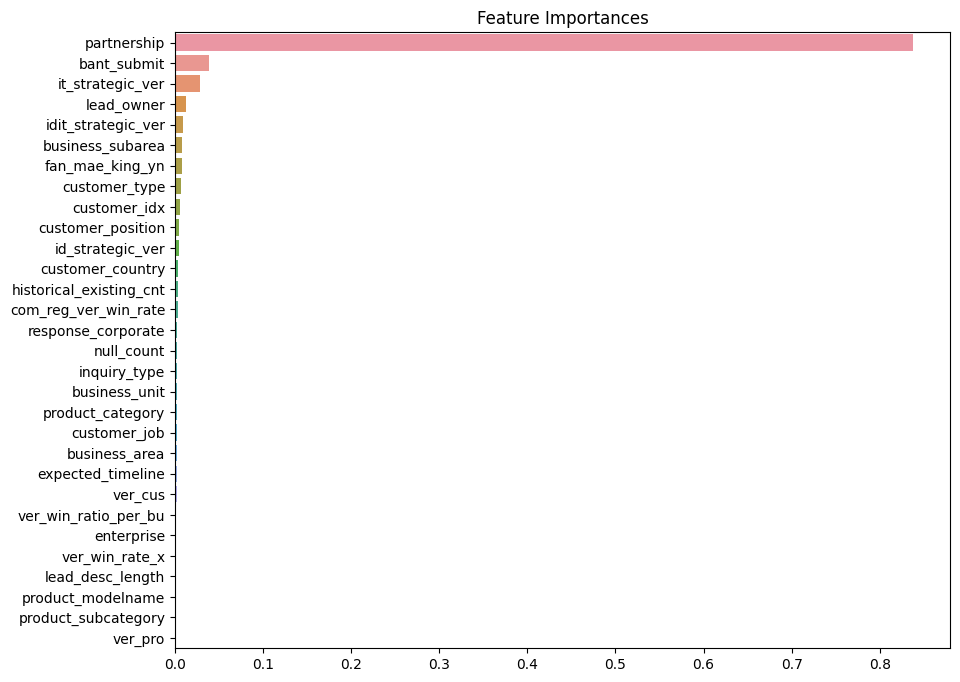

In [64]:
# 위 feature importance를 시각화해봅니다.
importances_xgb = pd.Series(best_model_xgb.feature_importances_, index=list(X_train.columns))
importances_xgb = importances_xgb.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_xgb, y=importances_xgb.index)
plt.show()

In [65]:
y_pred_proba_xgb = best_model_xgb.predict_proba(X_val)[:, 1]

In [66]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val, y_pred_proba_xgb)

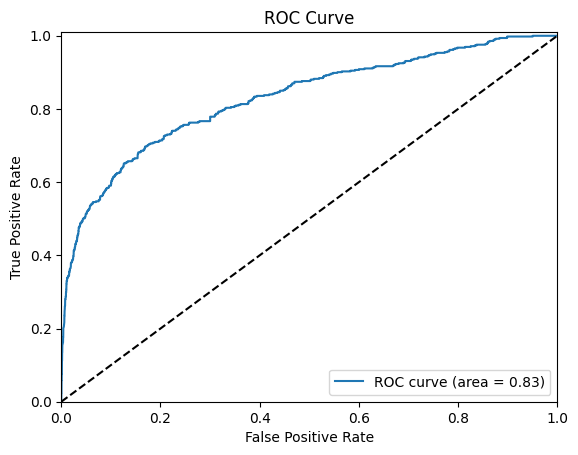

In [67]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='ROC curve (area = %0.2f)' % auc(fpr_xgb, tpr_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [68]:
# 적정 임계값 찾기
optimal_idx_xgb = np.argmax(tpr_xgb - fpr_xgb)
optimal_threshold_xgb = thresholds_xgb[optimal_idx_xgb]
print("Optimal threshold:", optimal_threshold_xgb)

Optimal threshold: 0.99975866


In [69]:
y_pred_custom_threshold_xgb = (y_pred_proba_xgb >= optimal_threshold_xgb).astype(int)

In [70]:
### 기본 쓰레스홀드
pred_xgb = best_model_xgb.predict(X_val)
get_clf_eval(y_val, pred_xgb)

오차행렬:
 [[ 493    0]
 [5091    0]]

정확도: 0.0883
정밀도: 0.0883
재현율: 1.0000
F1: 0.1623


In [71]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_xgb)

오차행렬:
 [[ 344  149]
 [ 862 4229]]

정확도: 0.8189
정밀도: 0.2852
재현율: 0.6978
F1: 0.4049


### 5. CATB

In [100]:
# category 찾기
category_columns_indices = [idx for idx, dtype in enumerate(X_train.dtypes) if dtype.name == 'category']

In [103]:
# optuna 학습 메소드 선언
def objective_CB(trial, X, y):
    param = {
        'iterations': trial.suggest_int('iterations', 100,1000),
        'depth': trial.suggest_int('depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2,50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log = True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'random_strength':trial.suggest_float('random_strength', 5e-3, 0.3),
        'cat_features':category_columns_indices
    }
    model = CatBoostClassifier(**param)
    
    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    cv = cross_val_score(model, X, y, scoring=f1_scorer, cv=skf).mean()
    
    return cv

In [104]:
%%time
study_cb = optuna.create_study(study_name='CB', direction="maximize")
study_cb.optimize(lambda trial: objective_CB(trial, X_train, y_train),
                  n_trials = n_trial)

[I 2024-02-22 17:50:55,793] A new study created in memory with name: CB
[W 2024-02-22 17:50:55,977] Trial 0 failed with parameters: {'iterations': 689, 'depth': 15, 'min_data_in_leaf': 18, 'learning_rate': 0.0020333207083445422, 'subsample': 0.35043544212858413, 'random_strength': 0.28004640641976447} because of the following error: ValueError('\nAll the 10 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n10 fits failed with the following error:\nTraceback (most recent call last):\n  File "_catboost.pyx", line 2684, in _catboost._set_features_order_data_pd_data_frame_categorical_column\n  File "_catboost.pyx", line 1892, in _catboost.get_id_object_bytes_string_representation\n_catboost.CatBoostError: bad object for id: 0.0\n\nDuring handling of the above exception, another exce

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2684, in _catboost._set_features_order_data_pd_data_frame_categorical_column
  File "_catboost.pyx", line 1892, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 0.0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 2303, in _fit
    train_params = self._prepare_train_params(
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 2184, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 1444, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 793, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/home/elicer/.local/lib/python3.10/site-packages/catboost/core.py", line 1425, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3976, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4026, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3842, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2769, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2686, in _catboost._set_features_order_data_pd_data_frame_categorical_column
_catboost.CatBoostError: Invalid type for cat_feature category for [feature_idx=0]=0.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.


In [74]:
# print하자
print('Best trial: score {}, \nparams {}'.format(study_cb.best_trial.value,
                                                 study_cb.best_trial.params))

ValueError: No trials are completed yet.

In [ ]:
# best models for rf
best_params_cb = study_cb.best_params
best_model_cb = CatBoostClassifier(**best_params_cb, random_state=42)
best_model_cb.fit(X_train, y_train)

In [ ]:
# 위 feature importance를 시각화해봅니다.
importances_cb = pd.Series(best_model_cb.feature_importances_, index=list(X_train.columns))
importances_cb = importances_cb.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_cb, y=importances_cb.index)
plt.show()

In [ ]:
y_pred_proba_cb = best_model_cb.predict_proba(X_val)[:, 1]

In [ ]:
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_val, y_pred_proba_cb)

In [ ]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_cb, tpr_cb, label='ROC curve (area = %0.2f)' % auc(fpr_cb, tpr_cb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 적정 임계값 찾기
optimal_idx_cb = np.argmax(tpr_cb - fpr_cb)
optimal_threshold_cb = thresholds_cb[optimal_idx_cb]
print("Optimal threshold:", optimal_threshold_cb)

In [ ]:
y_pred_custom_threshold_cb = (y_pred_proba_cb >= optimal_threshold_cb).astype(int)

In [ ]:
### 기본 쓰레스홀드
pred_cb = best_model_cb.predict(X_val)
get_clf_eval(y_val, pred_cb)

In [ ]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_cb)

### 6. Hard Voting

In [105]:
# hard voting
hard_voting_model = VotingClassifier(estimators=[#('Random Forest', best_model_rf),
                                                 ('Extra Tree', best_model_et),
                                                 ('Light GBM', best_model_lgbm),
                                                 ('eXtreme GB', best_model_xgb)#,
                                                 #('CatBoost', best_model_cb)
                                                ],
                                     voting='hard')

In [106]:
hard_voting_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 46124, number of negative: 46124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 92248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('Extra Tree',
                              ExtraTreesClassifier(bootstrap=True,
                                                   criterion='entropy',
                                                   max_depth=13,
                                                   max_features=0.4910975500533088,
                                                   min_impurity_decrease=0.024470532883400998,
                                                   min_samples_leaf=9,
                                                   min_samples_split=8,
                                                   n_estimators=102,
                                                   random_state=42)),
                             ('Light GBM',
                              LGBMClassifier(colsample_bytree=0.8905093899855834,
                                             learning_rate=0.02844678173...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.038656302483763276,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=804, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [107]:
# predict & confusion Matrix
pred_hard_voting = hard_voting_model.predict(X_val)
get_clf_eval(y_val, pred_hard_voting)

오차행렬:
 [[ 363  130]
 [  59 5032]]

정확도: 0.9662
정밀도: 0.8602
재현율: 0.7363
F1: 0.7934


In [108]:
y_pred_proba_hv = hard_voting_model.predict_proba(X_val)[:, 1]

AttributeError: predict_proba is not available when voting='hard'

In [ ]:
fpr_hv, tpr_hv, thresholds_hv = roc_curve(y_val, y_pred_proba_hv)

In [ ]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_hv, tpr_hv, label='ROC curve (area = %0.2f)' % auc(fpr_hv, tpr_hv))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 적정 임계값 찾기
optimal_idx_hv = np.argmax(tpr_hv - fpr_hv)
optimal_threshold_hv = thresholds_hv[optimal_idx_hv]
print("Optimal threshold:", optimal_threshold_hv)

In [ ]:
y_pred_custom_threshold_hv = (y_pred_proba_hv >= optimal_threshold_hv).astype(int)

In [ ]:
### 기본 쓰레스홀드
pred_hv = best_model_hv.predict(X_val)
get_clf_eval(y_val, pred_hv)

In [ ]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_hv)

### 7. Soft Voting

In [109]:
# soft voting
soft_voting_model = VotingClassifier(estimators=[#('Random Forest', best_model_rf),
                                                 ('Extra Tree', best_model_et),
                                                 ('Light GBM', best_model_lgbm),
                                                 ('eXtreme GB', best_model_xgb)#,
                                                 #('CatBoost', best_model_cb)
                                                ],
                                     voting='soft',
                                     weights=[1, 1, 1])

In [110]:
soft_voting_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 46124, number of negative: 46124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 92248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('Extra Tree',
                              ExtraTreesClassifier(bootstrap=True,
                                                   criterion='entropy',
                                                   max_depth=13,
                                                   max_features=0.4910975500533088,
                                                   min_impurity_decrease=0.024470532883400998,
                                                   min_samples_leaf=9,
                                                   min_samples_split=8,
                                                   n_estimators=102,
                                                   random_state=42)),
                             ('Light GBM',
                              LGBMClassifier(colsample_bytree=0.8905093899855834,
                                             learning_rate=0.02844678173...
                                            interaction_constraints=None,
                                            learning_rate=0.038656302483763276,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=804, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[1, 1, 1])

In [111]:
# predict & confusion Matrix
pred_soft_voting = soft_voting_model.predict(X_val)
get_clf_eval(y_val, pred_soft_voting)

오차행렬:
 [[ 440   53]
 [ 392 4699]]

정확도: 0.9203
정밀도: 0.5288
재현율: 0.8925
F1: 0.6642


In [112]:
y_pred_proba_sv = soft_voting_model.predict_proba(X_val)[:, 1]

In [113]:
fpr_sv, tpr_sv, thresholds_sv = roc_curve(y_val, y_pred_proba_sv)

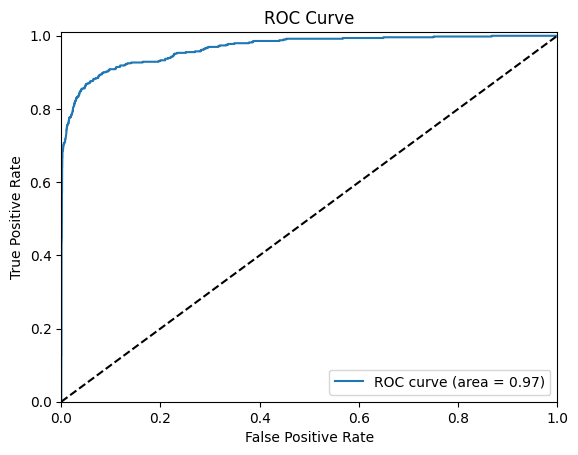

In [114]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_sv, tpr_sv, label='ROC curve (area = %0.2f)' % auc(fpr_sv, tpr_sv))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [115]:
# 적정 임계값 찾기
optimal_idx_sv = np.argmax(tpr_sv - fpr_sv)
optimal_threshold_sv = thresholds_sv[optimal_idx_sv]
print("Optimal threshold:", optimal_threshold_sv)

Optimal threshold: 0.5201329625309854


In [116]:
y_pred_custom_threshold_sv = (y_pred_proba_sv >= optimal_threshold_sv).astype(int)

In [118]:
### 기본 쓰레스홀드
pred_sv = soft_voting_model.predict(X_val)
get_clf_eval(y_val, pred_sv)

오차행렬:
 [[ 440   53]
 [ 392 4699]]

정확도: 0.9203
정밀도: 0.5288
재현율: 0.8925
F1: 0.6642


In [119]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_sv)

오차행렬:
 [[ 428   65]
 [ 253 4838]]

정확도: 0.9431
정밀도: 0.6285
재현율: 0.8682
F1: 0.7291


### 8. Stacking

In [122]:
estimators=[
    #('Random Forest', best_model_rf),
    ('Extra Tree', best_model_et),
    ('Light GBM', best_model_lgbm),
    ('eXtreme GB', best_model_xgb),
    #('CatBoost', best_model_cb),
    #('Hard_voting', hard_voting_model),
    ('Soft_voting', soft_voting_model)
]
stacking_model = StackingClassifier(
     estimators=estimators,
     final_estimator=LogisticRegression()
)

In [123]:
stacking_model.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 46124, number of negative: 46124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9802
[LightGBM] [Info] Number of data points in the train set: 92248, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positiv

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 36899, number of negative: 36900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8262
[LightGBM] [Info] Number of data points in the train set: 73799, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499993 -> initscore=-0.000027
[LightGBM] [Info] Start training from score -0.000027


StackingClassifier(estimators=[('Extra Tree',
                                ExtraTreesClassifier(bootstrap=True,
                                                     criterion='entropy',
                                                     max_depth=13,
                                                     max_features=0.4910975500533088,
                                                     min_impurity_decrease=0.024470532883400998,
                                                     min_samples_leaf=9,
                                                     min_samples_split=8,
                                                     n_estimators=102,
                                                     random_state=42)),
                               ('Light GBM',
                                LGBMClassifier(colsample_bytree=0.8905093899855834,
                                               learning_rate=0.028446781...
                                                                            learning_rate=0.038656302483763276,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=8,
                                                                            max_leaves=None,
                                                                            min_child_weight=7,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=804,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=42, ...))],
                                                 voting='soft',
                                                 weights=[1, 1, 1]))],
                   final_estimator=LogisticRegression())

In [124]:
# predict & confusion Matrix
pred_stacking = stacking_model.predict(X_val)
get_clf_eval(y_val, pred_stacking)

오차행렬:
 [[ 493    0]
 [5091    0]]

정확도: 0.0883
정밀도: 0.0883
재현율: 1.0000
F1: 0.1623


In [125]:
y_pred_proba_stack = stacking_model.predict_proba(X_val)[:, 1]

In [128]:
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_val, y_pred_proba_stack)

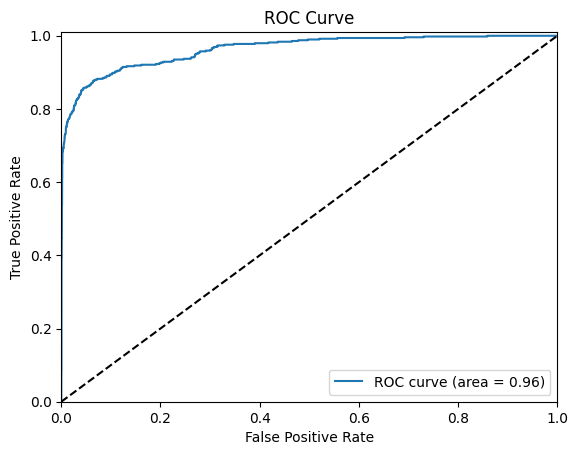

In [129]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr_stack, tpr_stack, label='ROC curve (area = %0.2f)' % auc(fpr_stack, tpr_stack))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [130]:
# 적정 임계값 찾기
optimal_idx_stack = np.argmax(tpr_stack - fpr_stack)
optimal_threshold_stack = thresholds_stack[optimal_idx_stack]
print("Optimal threshold:", optimal_threshold_stack)

Optimal threshold: 0.9042620078944765


In [131]:
y_pred_custom_threshold_stack = (y_pred_proba_stack >= optimal_threshold_stack).astype(int)

In [132]:
### 기본 쓰레스홀드
pred_stack = stacking_model.predict(X_val)
get_clf_eval(y_val, pred_stack)

오차행렬:
 [[ 493    0]
 [5091    0]]

정확도: 0.0883
정밀도: 0.0883
재현율: 1.0000
F1: 0.1623


In [133]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold_stack)

오차행렬:
 [[ 423   70]
 [ 228 4863]]

정확도: 0.9466
정밀도: 0.6498
재현율: 0.8580
F1: 0.7395


# 제출용 데이터 만들기

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [ ]:
# lgbm_params = best_params

In [ ]:
# # best_params = study.best_params
# best_model_lgbm = LGBMClassifier(
# #                            **best_params,
#                            **lgbm_params,
#                            random_state=1996)

# test_pred_lgbm = best_model_lgbm.fit(X,y).predict(x_test)
# sum(test_pred_lgbm) # True로 예측된 개수

In [ ]:
# y_pred_proba_lgbm = best_model_lgbm.predict_proba(x_test)[:, 1]  # 양성 클래스에 대한 확률
# y_pred_custom_threshold_lgbm = (y_pred_proba_lgbm >= optimal_threshold_lgbm).astype(int)

In [ ]:
# sum(y_pred_custom_threshold_lgbm)

In [ ]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["is_converted"] = y_pred_custom_threshold

# # 제출 파일 저장
# df_sub.to_csv("submission.csv", index=False)